## Import libraries

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#sns.set()
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Data visualization on a few samples

Let's look at 5 random controls and 5 random PanIN samples. This is only to start to get an idea of what the spectrometry data looks like. 

First things first. The data files have very long names. I couldn't find out if thesse names were associated with some kind of information. I will start off by renaming all files in each folder to something more digestible. I may have to revisit this step if the file name do in fact, turn out to be important. Only one way to find out. 

In [137]:
import os

# Switch to folder with 'control' files
os.chdir(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control')

# Check if I'm in the right directory
#print(os.getcwd())

# Create arrays to store new file names
control_samples = []
panIN_samples = []

# Rename files in the Control folder
for file in os.listdir():
    #print(file)     # Get file names
    #print(os.path.splitext(file))     # Separate file name from extension
    file_name, file_ext = os.path.splitext(file)     # Store the file name and extensions
    new_name = '{}{}'.format(file_name.split('_')[0], file_ext)     # Grab the first identifying number for each file
    #print(new_name)     # Confirm that the name we have the name we want
    os.rename(file,new_name)     # Rename files
    control_samples.append(file)     # Append new file names to array
    
# Rename files in the PanIN folder
os.chdir(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN')
for file in os.listdir():
    file_name, file_ext = os.path.splitext(file)     # Store the file name and extensions
    new_name = '{}{}'.format(file_name.split('_')[0], file_ext)     # Grab the first identifying number for each file
    #print(new_name)     # Confirm that the name we have the name we want
    os.rename(file,new_name)     # Rename files
    panIN_samples.append(file)     # Append new file names to array
    
print(len(control_samples))
print(len(panIN_samples))

101
80


So we have 101 control samples and 80 PanIN samples. Not the biggest sample size but we work with what we have. 

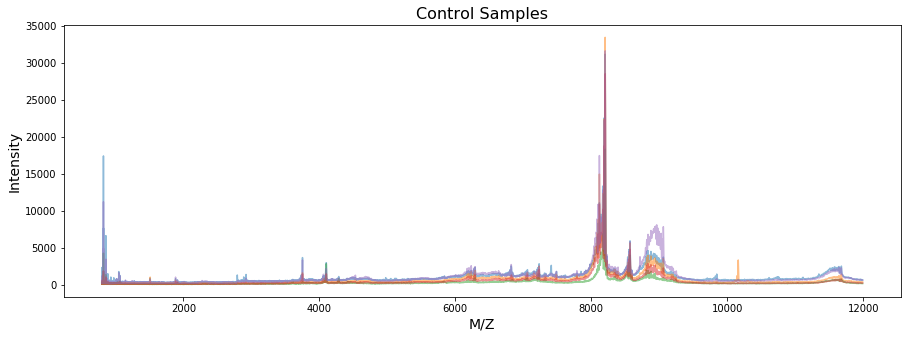

In [138]:
# Plot 5 random control samples
plt.figure(figsize=(15,5))
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Control Samples', fontsize=16)

# Read in 5 random Control samples
for i in range(0,5):
    n = np.random.randint(low=0, high=len(control_samples))
    cs = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\{}'.format(control_samples[n]))
    plt.plot(cs['M/Z'], cs['Intensity'], alpha=0.5)

On a quick (and crude) visual inspection, the spectrometry files seem to show consistent peaks for the 5 random control samples. Let's try the same for the PanIN samples.

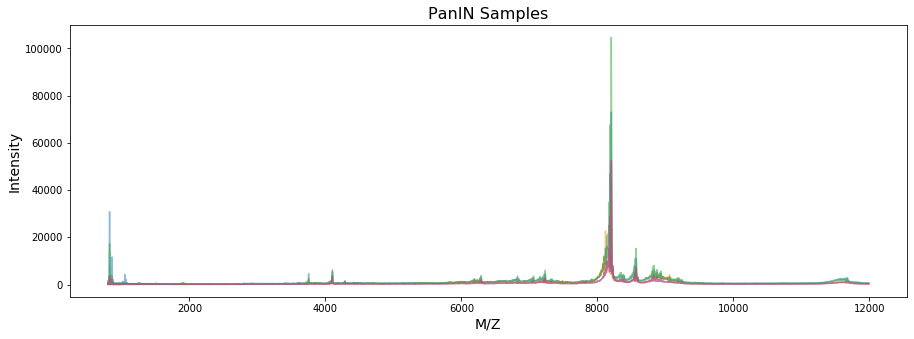

In [139]:
# Plot 5 random PanIN samples
plt.figure(figsize=(15,5))
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('PanIN Samples', fontsize=16)

# Read in 5 random PanIN samples
for i in range(0,5):
    n = np.random.randint(low=0, high=len(panIN_samples))
    ps = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\{}'.format(panIN_samples[n]))
    plt.plot(ps['M/Z'], ps['Intensity'], alpha=0.5)

Some PanIN samples show random peaks, but overall the peaks still seem fairly consistent. Now let's compare the controls and PanIN samples.

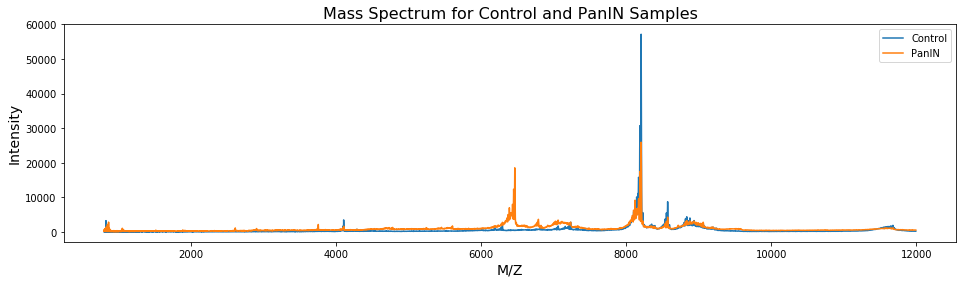

In [174]:
n = np.random.randint(low=0, high=len(control_samples))
cs = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\02-Control\{}'.format(control_samples[n]))
m = np.random.randint(low=0, high=len(panIN_samples))
ps = pd.read_csv(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Data\03-PanIN\{}'.format(panIN_samples[m]))
                                                                                                                      
plt.figure(figsize=[16,4])
plt.plot(cs['M/Z'], cs['Intensity'], label='Control')
plt.plot(ps['M/Z'], ps['Intensity'], label='PanIN')
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Mass Spectrum for Control and PanIN Samples', fontsize=16)
plt.legend()
plt.savefig(r'C:\Users\sriha\OneDrive\Desktop\DS\My work\diagnosing-pancreatic-cancer\Figures\Mass Spectrum.png')

If we were to just try to visually compare the spectra for a control and a PanIN sample, we could identify some peaks fairly well. But it would be quite difficult to identify all the key biomarkers. This is why we are trying to train a model to do this for us! 

In [165]:
cs.head()

,M/Z,Intensity
0,800.00000,98.0
1,800.32000,178.0
2,800.64014,65.0
3,800.96040,143.0
4,801.28076,239.0


### Noise Reduction and Scaling Data
The idea here is to reduce noise and scale the data without losing any information. Using a standard scaler object did not seem to give good results, so I have attempted to manually scale the data. 

In [166]:
# Baseline subtraction: Subtract the median of the bottom 5% of intensity values from all the values. 
# This should capture some of the noise. Might have to play around a little bit to make sure no information is lost. 

bottom5_median = np.median(np.sort(cs['Intensity'])[:len(cs['Intensity'])//5])

# Make sure that the lowest values are 0 and not negative
cs['Intensity'] = cs['Intensity'].apply(lambda x: x if x > 0 else 0)
cs.head()

,M/Z,Intensity
0,800.00000,98.0
1,800.32000,178.0
2,800.64014,65.0
3,800.96040,143.0
4,801.28076,239.0


In [176]:
# Rescaling: Divide all the values by the highest intensity value
cs['Intensity'] = cs['Intensity'] / np.max(cs['Intensity'])

# Take the square root to 'compress' the intensity values a little. 
# The actual intensity values are not important. We just need to be able to identify and visualize the peaks.  
cs['Intensity'] = np.sqrt(cs['Intensity'])
cs.describe()

,M/Z,Intensity
count,6771.000000,6771.000000
mean,4134.434794,0.064119
std,3059.113720,0.046512
min,800.000000,0.026123
25%,1574.160100,0.037414
50%,3097.470200,0.047694
75%,6094.888700,0.071111
max,11992.908000,1.000000


Let's now visualize this information as a colorbar, along with the spectrogram. The colorbar is simly a different way to visualize the spectrogram information. The more yellow the vertical line, the higher the intensity at that M/Z value. 

Note that most of the colorbar here will be blue, meaning the intensities for most of the M/Z values are near zero. The colorbar would be alot more useful if the intensity values were normalized from the device at the time of data collection. 

Text(0.5, 0, 'M/Z')

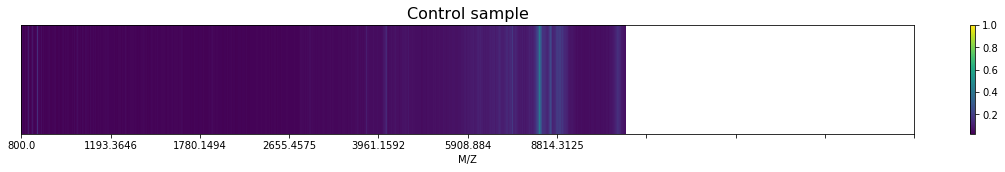

In [190]:
# Plot the spectrogram as a colorbar
plt.figure(figsize =(20,2))
plt.title('Control sample', fontsize = 16)
plt.imshow(cs['Intensity'][np.newaxis,:], aspect = 'auto', cmap='viridis')
plt.yticks([])
plt.xticks(np.arange(0,11000,1000), cs['M/Z'][0:11000:1000])
plt.colorbar()
plt.xlabel('M/Z')

Text(0.5, 1.0, 'Mass Spectrum for Control and PanIN Samples')

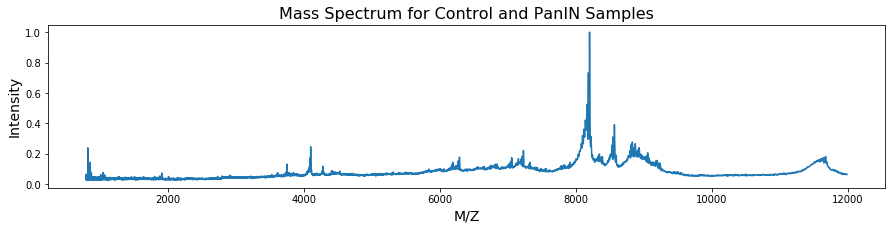

In [196]:
# Plot as a regular intensity vs M/Z plot
plt.figure(figsize=[15,3])
plt.plot(cs['M/Z'], cs['Intensity'])
plt.xlabel('M/Z', fontsize=14)
plt.ylabel('Intensity', fontsize=14)
plt.title('Mass Spectrum for Control and PanIN Samples', fontsize=16)

Scaling definitely helped with the visualization. Peaks are much more clearly observable now. 